In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
import os
from time import time, sleep
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

from utils import generate_run_id, get_input_args, Args, parse_run_id
from models import Discriminator_FC, Generator_MNIST, Weight_Clipper, G_weights_init, Generator_FC, Encoder_Mini, Decoder_Mini, VAE, Encoder_VAE, Decoder_VAE
from data import load_MNIST
from metrics import get_IS, get_FID
from model_inversion import enc_fp, dec_fp, gen_fp
from evaluate_metrics import last_num_models

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_fp = "output_plots"

## Setup

In [2]:
pub_G = Generator_FC(hidden_sizes=[256], nz=100).to(device)
pub_G.load_state_dict(torch.load(gen_fp))

pub_Dec = Decoder_Mini(latent_size=100).to(device)
pub_Dec.load_state_dict(torch.load(dec_fp))

pub_Enc = Encoder_Mini(latent_size=100).to(device)
pub_Enc.load_state_dict(torch.load(enc_fp))

pub_G.eval()
pub_Dec.eval()
pub_Enc.eval()
print("Loaded public models")

Loaded public models


In [3]:
# Get run_ids from the final experiment
hiddens = [64]
noise_multipliers = [0.3, 0.4, 0.5, 0.6]
activations = ["LeakyReLU", "Tanh", ]
c_ps = [0.5, 0.25, 0.1, 0.05]
lrs = [0.01, 0.02]

from itertools import product

valid_run_ids = []
for activation, c_p, noise_multiplier, lr in product(
        activations, c_ps, noise_multipliers, lrs):
    args = Args(
        hidden=[64], nz=32, ngf=32, nc=1, activation=activation,
        epsilon=50.0, delta=1e-6, noise_multiplier=noise_multiplier, c_p=c_p,
        lr=lr, beta1=0.5, batch_size=64, n_d=0, n_g=48000, lambda_gp=0.0
    )
    run_id = "ae-grad_" + generate_run_id(args)
    if os.path.exists("runs_vae/{}".format(run_id)):
        valid_run_ids.append(run_id)
print("# of experiments:", len(valid_run_ids))

# of experiments: 64


In [4]:
from scipy.interpolate import interp1d
import pickle

def calculate_epsilon_used(run_fp):
    """Calculates the epsilon used for a given noise_multiplier
    We need to linearly extrapolate past a few thousand batches since
        the accountant uses too much memory and gets killed
    """   
    run_id = run_fp.split("/")[-1]
    args = parse_run_id(run_id)

    # Check epsilon_fn.pkl
    if os.path.exists(f"{run_fp}/epsilon_fn.pkl"):
        print("Computed already")
        with open(f"{run_fp}/epsilon_fn.pkl", "rb") as file:
            epsilon_fn = pickle.load(file)
        return args.noise_multiplier, epsilon_fn

    # Read in loss file
    # Lines look like:
    with open(f"{run_fp}/loss.txt", "r") as f:
        lines = f.readlines()
    epsilons = []
    for line in lines:
        if "Epsilon" in line:
            batch_idx, eps = line.split(" ")[1:]
            epsilons.append([float(batch_idx), float(eps)])
    epsilons = np.array(epsilons)

    # Linearly interpolate to get the epsilon used
    epsilon_fn = interp1d(epsilons[:, 0], epsilons[:, 1], kind="linear", fill_value="extrapolate")
    
    # Pickle the function
    with open(f"{run_fp}/epsilon_fn.pkl", "wb") as file:
        pickle.dump(epsilon_fn, file)
    
    return args.noise_multiplier, epsilon_fn

# Load functions
folder = "runs_vae_eps"
epsilon_fns = {}
for run_id in os.listdir(folder):
    run_fp = f"{folder}/{run_id}"
    noise_multiplier, epsilon_fn = calculate_epsilon_used(run_fp)
    epsilon_fns[noise_multiplier] = epsilon_fn
sorted(list(epsilon_fns.keys()))

Computed already
Computed already
Computed already
Computed already
Computed already


[0.2, 0.3, 0.4, 0.5, 0.6]

In [118]:
def generate_samples(G, args, latent_type=None, plot=True, batch_size=32, seed=False):
    if seed:
        torch.manual_seed(100)

    # Generate Sample Images
    noise = torch.randn(batch_size, args.nz).to(device)
    if latent_type == "wgan":
        output = G(noise)
        fake = pub_G(output)
    elif latent_type == "ae":
        output = G(noise)
        fake = pub_Dec(output)
    else:
        fake = G(noise)
    fake = fake.view(fake.size(0), 1, 28, 28)
    
    # Plot Sample Images
    if plot:
        fig, ax = plt.subplots(4, 8, figsize=(10, 5))
        for i in range(4):
            for j in range(8):
                ax[i, j].imshow(fake[i*8+j][0].detach().cpu().numpy(), cmap='gray')
                ax[i, j].axis('off')
        plt.show()
        plt.close()

    return fake

## Metric Evaluation

In [8]:
# Initial runs
df_1 = pd.read_csv("results/vae_results.csv")
df_2 = pd.read_csv("results/vae_FID.csv")

df_initial = df_1.merge(df_2, on="model_fp", suffixes=("", "_fid"))
# Drop non-48000 n_g
df_initial = df_initial[df_initial["n_g"] == 48000]

# Second runs
df_1 = pd.read_csv("results/vae_IS_final.csv")
df_2 = pd.read_csv("results/vae_FID_final.csv")

# df_2 if FID is not NaN
df_2 = df_2[~df_2["FID"].isna()]
# drop nan columns
df_2 = df_2.dropna(axis=1)

# Join df and df_2 on model_fp
df_second = df_1.merge(df_2, on="model_fp", suffixes=("", "_fid"))

# Third runs
df_1 = pd.read_csv("results/vae_IS_final_2.csv")
df_2 = pd.read_csv("results/vae_FID_final_2.csv")
df_final = df_1.merge(df_2, on="model_fp", suffixes=("", "_fid"))

# Third runs (halfway)
df_1 = pd.read_csv("results/vae_IS_final_half.csv")
df_2 = pd.read_csv("results/vae_FID_final_half.csv")
df_final_half = df_1.merge(df_2, on="model_fp", suffixes=("", "_fid"))
df_final_half["n_g"] = 24000

# Take columns of interest
cols = ["noise_multiplier", "c_p", "n_g", "activation", "lr", "IS", "FID", "model_fp"]
df_initial = df_initial[cols]
df_second = df_second[cols]
df_final = df_final[cols]
df_final_half = df_final_half[cols]

In [40]:
# Stack dataframes
df = pd.concat([df_initial, df_second, df_final, df_final_half], axis=0)

# Valid noise_multipliers
noise_multipliers = [0.2, 0.3 ,0.4, 0.5, 0.6]
df = df[df["noise_multiplier"].isin(noise_multipliers)]
df = df.reset_index(drop=True)

# Calculate epsilon used
for idx, row in df.iterrows():
    noise_multiplier = row.noise_multiplier
    n_g = row.n_g
    epsilon_fn = epsilon_fns[noise_multiplier]
    epsilon_used = epsilon_fn(n_g)
    df.loc[idx, "epsilon"] = epsilon_used
df["delta"] = 1e-6

# Rename model_fp to run_fp
df = df.rename(columns={"model_fp": "run_fp"})
df.head()

,noise_multiplier,c_p,n_g,activation,lr,IS,FID,run_fp,epsilon,delta
0,0.3,0.5,48000,LeakyReLU,0.01,2.076014,141.832750,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.3_0.5...,367.702807,0.000001
1,0.4,0.5,48000,LeakyReLU,0.01,2.068468,151.103250,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.4_0.5...,107.210127,0.000001
2,0.5,0.5,48000,LeakyReLU,0.01,NaN,500.556752,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.5_0.5...,41.674922,0.000001
3,0.3,0.1,48000,LeakyReLU,0.01,1.575021,125.436456,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.3_0.1...,367.702807,0.000001
4,0.4,0.1,48000,LeakyReLU,0.01,1.980428,139.305805,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.4_0.1...,107.210127,0.000001


In [41]:
df = df.sort_values(by=["epsilon", "FID"])
df = df.reset_index(drop=True)
print(len(df))
print(df["epsilon"].unique())
df.head()

146
[ 12.69233582  20.75029415  25.23957193  41.674922    63.06698782
 107.210127   207.72618642 367.70280659]


,noise_multiplier,c_p,n_g,activation,lr,IS,FID,run_fp,epsilon,delta
0,0.6,0.10,24000,Tanh,0.02,1.703985,147.481742,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.6_0.1...,12.692336,0.000001
1,0.6,0.05,24000,LeakyReLU,0.02,1.901110,147.931720,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.6_0.0...,12.692336,0.000001
2,0.6,0.25,24000,Tanh,0.01,1.619000,149.056917,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.6_0.2...,12.692336,0.000001
3,0.6,0.05,24000,Tanh,0.02,1.774253,151.058367,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.6_0.0...,12.692336,0.000001
4,0.6,0.25,24000,LeakyReLU,0.01,1.988303,151.921673,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.6_0.2...,12.692336,0.000001


In [82]:
# Group by epsilon, find the lowest
df_best = df.groupby("epsilon").apply(lambda x: x[x["FID"] == x["FID"].min()])
df_best = df_best.reset_index(drop=True)
df_best

,noise_multiplier,c_p,n_g,activation,lr,IS,FID,run_fp,epsilon,delta
0,0.6,0.10,24000,Tanh,0.02,1.703985,147.481742,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.6_0.1...,12.692336,0.000001
1,0.6,0.25,48000,LeakyReLU,0.01,2.128093,152.636039,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.6_0.2...,20.750294,0.000001
2,0.5,0.05,24000,LeakyReLU,0.02,1.922493,147.569260,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.5_0.0...,25.239572,0.000001
3,0.5,0.05,48000,LeakyReLU,0.01,2.013799,146.361253,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.5_0.0...,41.674922,0.000001
4,0.4,0.25,24000,LeakyReLU,0.01,1.987227,147.900600,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.4_0.2...,63.066988,0.000001
5,0.4,0.10,48000,LeakyReLU,0.01,1.980428,139.305805,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.4_0.1...,107.210127,0.000001
6,0.3,0.50,24000,LeakyReLU,0.01,1.953695,144.174630,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.3_0.5...,207.726186,0.000001
7,0.3,0.10,48000,LeakyReLU,0.01,1.582065,124.568487,runs_vae/ae-grad_64_32_32_1_50.0_1e-06_0.3_0.1...,367.702807,0.000001


In [88]:
def run_fp_to_G_args(run_fp, n_g=48000):
    # Take top FID and grab model_fp
    run_id = run_fp.split("/")[-1]
    args = parse_run_id(run_id)

    # Get last model
    gen_fp = os.path.join(run_fp, f"vae_{n_g}.pt")

    # Load model
    vae = VAE(
        Encoder_VAE(args.hidden, latent_size=args.nz), 
        Decoder_VAE(args.hidden, latent_size=args.nz)
    ).to(device)
    vae.load_state_dict(torch.load(gen_fp))
    vae.eval()

    G = vae.decoder
    G.eval()
    return G, args

In [137]:
# Load in the best models
best_models = []
epsilons = []
fids = []
for idx, row in df_best.iterrows():
    run_fp = row.run_fp
    n_g = row.n_g
    eps = row.epsilon
    fid = row.FID

    G, args = run_fp_to_G_args(run_fp, n_g=n_g)

    best_models.append((args, G))
    epsilons.append(eps)
    fids.append(fid)
# Round epsilons and fids to 1 decimal place
epsilons = [round(eps, 1) for eps in epsilons]
fids = [round(fid, 1) for fid in fids]

epsilons, fids

([12.7, 20.8, 25.2, 41.7, 63.1, 107.2, 207.7, 367.7],
 [147.5, 152.6, 147.6, 146.4, 147.9, 139.3, 144.2, 124.6])

In [171]:
# Get a model that has uncomputable epsilon (too high it crashes)
best_initial = df_initial.groupby("noise_multiplier").apply(lambda x: x[x["FID"] == x["FID"].min()])
best_initial = best_initial.reset_index(drop=True)
noise, fid, run_fp = best_initial.loc[1][["noise_multiplier", "FID", "model_fp"]]
run_id = run_fp.split("/")[-1]
run_fp = f"runs_vae_tmp/{run_id}"
G, args = run_fp_to_G_args(run_fp, n_g=48000)
best_models.append((args, G))
epsilons.append("1000+")
fids.append(round(fid, 1))

epsilons, fids

([12.7, 20.8, 25.2, 41.7, 63.1, 107.2, 207.7, 367.7, '1000+'],
 [118.1, 127.5, 124.6, 144.2, 139.3, 147.9, 146.4, 147.6, 152.6, 147.5, 127.5])

In [139]:
# Get a model with inf epsilon
run_folder = "runs_vae_experiments"
run_id = "ae-grad_64_32_32_1_50.0_1e-06_0.0_1.0_0.01_0.5_64_0_100000_LeakyReLU_0.0"
run_fp = os.path.join(run_folder, run_id)
G, args = run_fp_to_G_args(run_fp, n_g=100000)

# Calculate FID
# Generate 2048 samples
z = torch.randn(2048, args.nz).to(device)
fake = pub_Dec(G(z))
# FID = get_FID(fake)
FID = 118.1135717727023

best_models.append((args, G))
epsilons.append("inf")
fids.append(round(FID, 1))

epsilons, fids

([12.7, 20.8, 25.2, 41.7, 63.1, 107.2, 207.7, 367.7, '1000+', 'inf'],
 [147.5, 152.6, 147.6, 146.4, 147.9, 139.3, 144.2, 124.6, 127.5, 118.1])

In [140]:
# Reverse order
best_models = best_models[::-1]
epsilons = epsilons[::-1]
fids = fids[::-1]

# Sample 8 images from each model
n_samples = 8
imgs = []
for args, G in best_models:
    fake = generate_samples(G, args, latent_type="ae", batch_size=n_samples, plot=False, seed=True)
    imgs.append(fake)

In [141]:
# Get a single batch of real private images
labeling_loader, public_loader, private_loader, test_loader = load_MNIST(8)

real_imgs, _ = next(iter(private_loader))
real_imgs = real_imgs.to(device)

Loading MNIST splits from disk


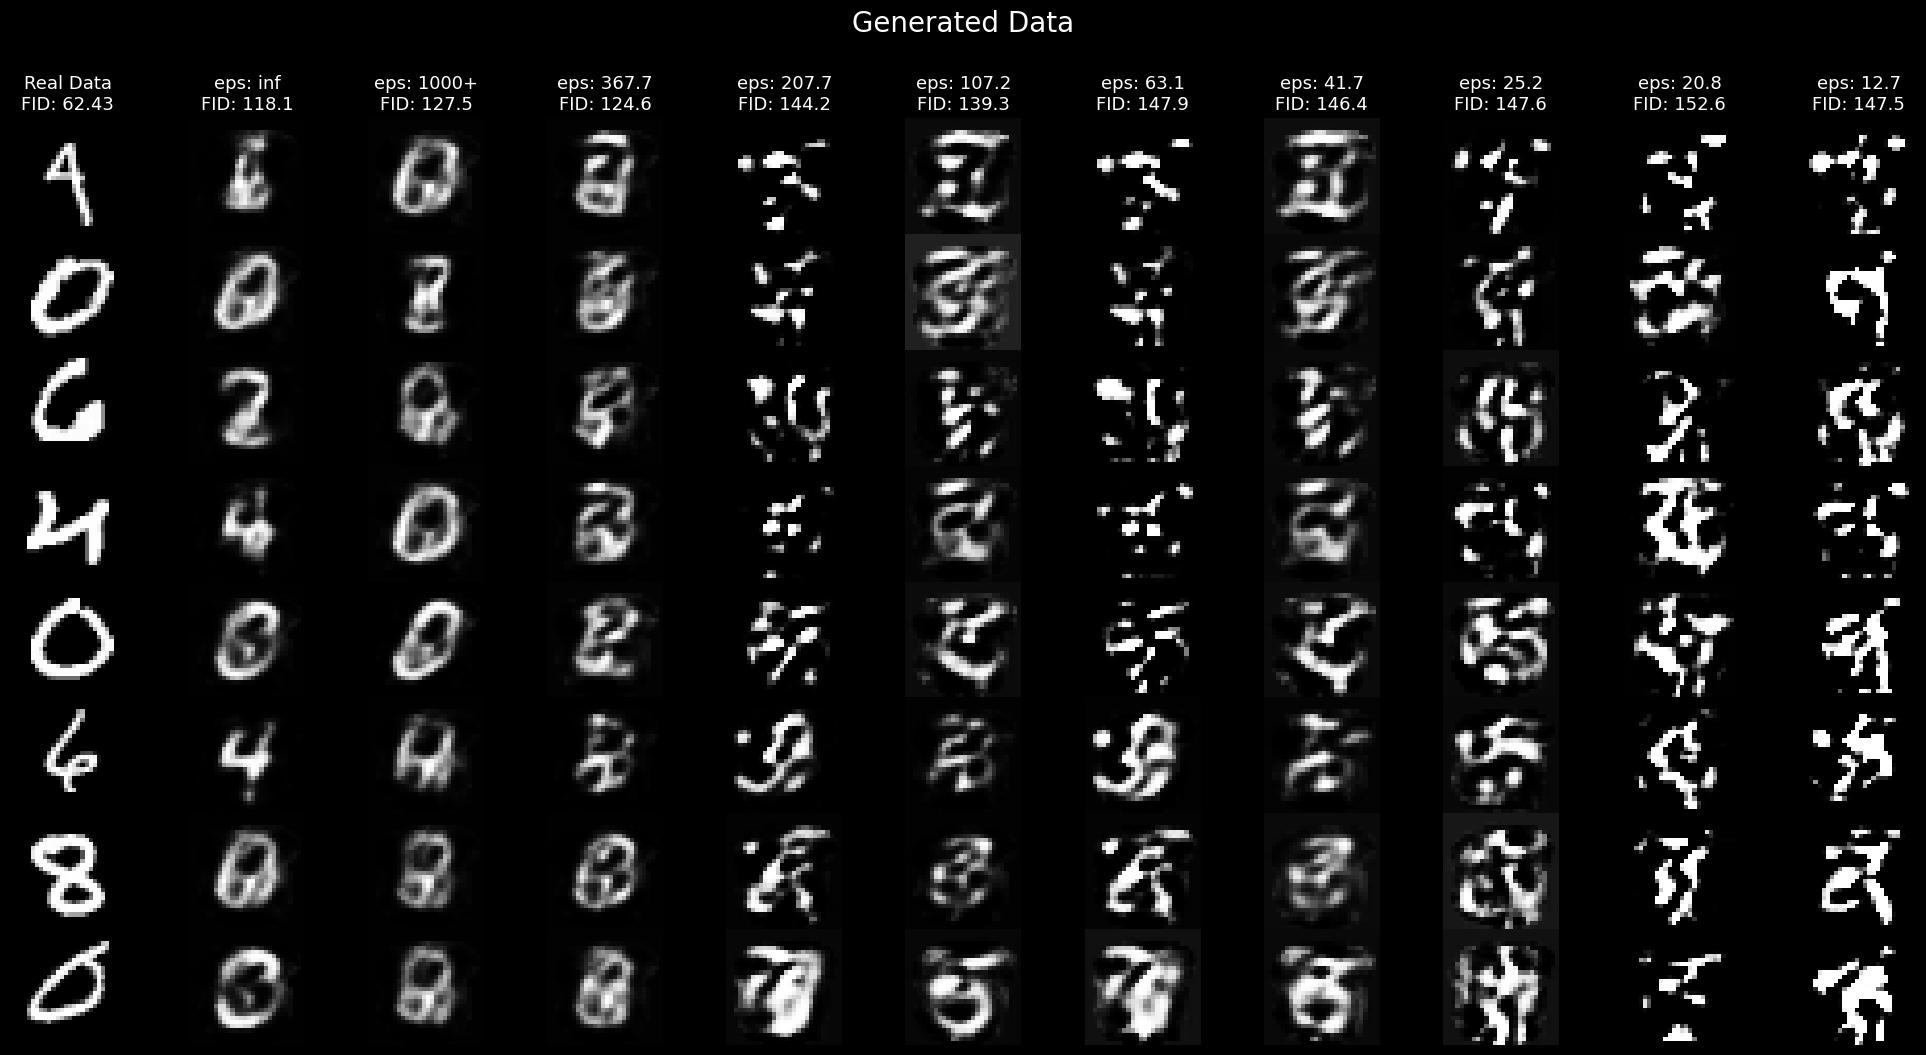

In [144]:
# Plot all images
fig, ax = plt.subplots(nrows=n_samples, ncols=len(best_models) + 1, figsize=(20, 10))
font_size = 13
color = "white"

# Real images
for i in range(n_samples):
    ax[i, 0].imshow(real_imgs[i].cpu().detach().numpy().squeeze(), cmap="gray")
    ax[i, 0].axis("off")
    if i == 0:
        ax[i, 0].set_title("Real Data\nFID: 62.43", fontsize=font_size, color=color)

for j in range(1, len(best_models) + 1):
    for i in range(n_samples):
        ax[i, j].imshow(imgs[j-1][i].cpu().detach().numpy().squeeze(), cmap="gray")
        ax[i, j].axis("off")
        if i == 0:
            ax[i, j].set_title(f"eps: {epsilons[j-1]}\nFID: {fids[j-1]}" , fontsize=font_size, color=color)
# black background
fig.patch.set_facecolor('black')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
# title
plt.suptitle("Generated Data", fontsize=20, y=1.05, color=color)
plt.savefig(f"{save_fp}/generated_data.png", bbox_inches='tight', pad_inches=0.25)
plt.show()

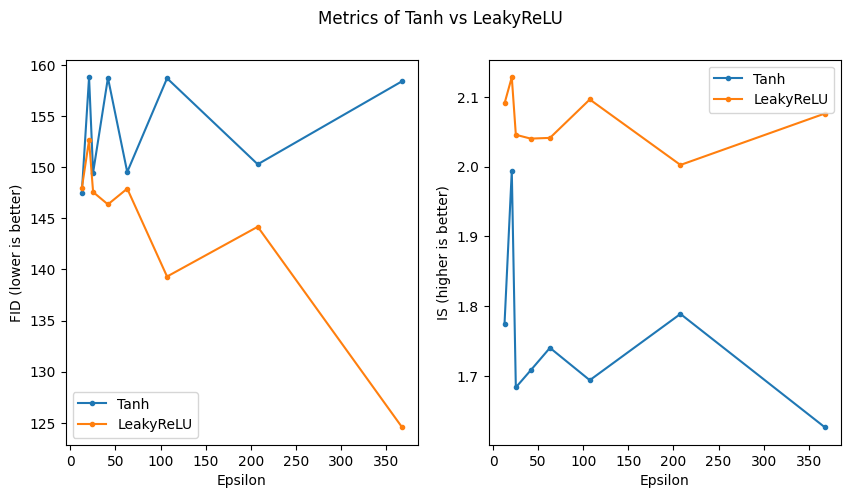

In [145]:
# Analysis of different variables

# tanh vs LeakyReLU, across different epsilons using data in df
df_tanh = df[df["activation"] == "Tanh"]
df_relu = df[df["activation"] == "LeakyReLU"]

# Group by epsilon, find the lowest FID
df_tanh_best = df_tanh.groupby("epsilon").apply(lambda x: x[x["FID"] == x["FID"].min()])
df_relu_best = df_relu.groupby("epsilon").apply(lambda x: x[x["FID"] == x["FID"].min()])
df_tanh_best = df_tanh_best.reset_index(drop=True)
df_relu_best = df_relu_best.reset_index(drop=True)

# Group by epsilon, find the highest IS
df_tanh_best_is = df_tanh.groupby("epsilon").apply(lambda x: x[x["IS"] == x["IS"].max()])
df_relu_best_is = df_relu.groupby("epsilon").apply(lambda x: x[x["IS"] == x["IS"].max()])

# Plot FID vs epsilon and IS vs epsilon
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(df_tanh_best["epsilon"], df_tanh_best["FID"], label="Tanh", marker=".")
ax[0].plot(df_relu_best["epsilon"], df_relu_best["FID"], label="LeakyReLU", marker=".")
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("FID (lower is better)")
ax[0].legend()

ax[1].plot(df_tanh_best_is["epsilon"], df_tanh_best_is["IS"], label="Tanh", marker=".")
ax[1].plot(df_relu_best_is["epsilon"], df_relu_best_is["IS"], label="LeakyReLU", marker=".")
ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("IS (higher is better)")
ax[1].legend()

fig.suptitle("Metrics of Tanh vs LeakyReLU")
plt.savefig(f"{save_fp}/activation.png", bbox_inches='tight', pad_inches=0.25)
plt.show()

In [152]:
# lines for different epsilons over x-axis: c_p and y-axis: FID and IS
epsilons = df["epsilon"].unique()
epsilons.sort()

# Seperate by epsilon
df_epsilons = []
for epsilon in epsilons:
    df_eps = df[df["epsilon"] == epsilon]

    # group by c_p, find the lowest FID
    df_best_cp_best = df_eps.groupby("c_p").apply(lambda x: x[x["FID"] == x["FID"].min()])
    df_best_cp_best = df_best_cp_best.reset_index(drop=True)

    # group by c_p, find the highest IS
    df_best_cp_best_is = df_eps.groupby("c_p").apply(lambda x: x[x["IS"] == x["IS"].max()])
    df_best_cp_best_is = df_best_cp_best_is.reset_index(drop=True)

    df_epsilons.append((df_best_cp_best, df_best_cp_best_is))

In [153]:
# Round epsilon values
epsilons = [round(epsilon, 1) for epsilon in epsilons]

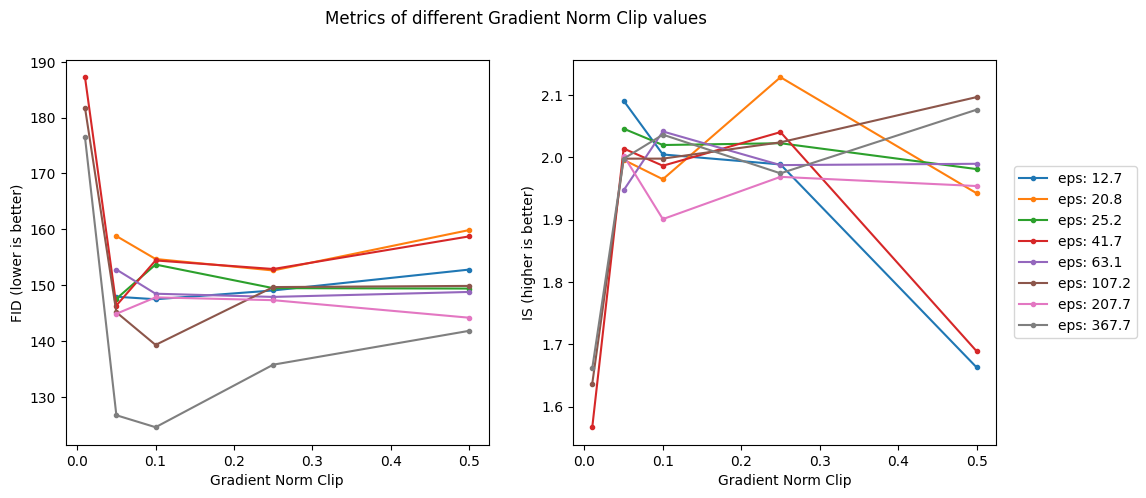

In [168]:
# Plot FID vs c_p and IS vs c_p
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, (df_best_cp_best, df_best_cp_best_is) in enumerate(df_epsilons):
    ax[0].plot(df_best_cp_best["c_p"], df_best_cp_best["FID"], label=f"eps: {epsilons[i]}", marker=".")
    ax[1].plot(df_best_cp_best_is["c_p"], df_best_cp_best_is["IS"], label=f"eps: {epsilons[i]}", marker=".")

ax[0].set_xlabel("Gradient Norm Clip")
ax[0].set_ylabel("FID (lower is better)")

ax[1].set_xlabel("Gradient Norm Clip")
ax[1].set_ylabel("IS (higher is better)")

# 1 legend to the right of both plots (outside of the plots)
ax[1].legend(loc="center right", bbox_to_anchor=(2.55, 0.5), bbox_transform=ax[0].transAxes)

fig.suptitle("Metrics of different Gradient Norm Clip values")
plt.savefig(f"{save_fp}/c_p.png", bbox_inches='tight', pad_inches=0.25)
plt.show()


## Visualization

In [174]:
def samples_during_training(run_fp, end=50000, step=5000, fname="during_train_vae.png"):
    # Parse args
    run_id = run_fp.split("/")[-1]
    args = parse_run_id(run_id)

    imgs = []
    for j in range(step, end + 1, step):
        gen_fp = f"vae_{j}.pt"
        gen_fp = os.path.join(run_fp, gen_fp)

        # Check if model exists
        if not os.path.exists(gen_fp):
            print("Model does not exist", gen_fp)
            raise ValueError("Model does not exist")

        vae = VAE(
            Encoder_VAE(args.hidden, latent_size=args.nz), 
            Decoder_VAE(args.hidden, latent_size=args.nz)
        ).to(device)
        vae.load_state_dict(torch.load(gen_fp))
        vae.eval()

        G = vae.decoder
        G.eval()

        fake = generate_samples(
            G, args, latent_type="wgan" if run_id.startswith("wgan") else "ae", 
            plot=False, batch_size=10, seed=True
        )
        imgs.append(fake)
    
    # Plot Sample Images
    n = len(imgs)
    fig, ax = plt.subplots(10, n)
    for i in range(10):
        for j in range(n):
            ax[i, j].imshow(imgs[j][i][0].detach().cpu().numpy(), cmap='gray')
            ax[i, j].axis('off')
            if i == 0:
                ax[i, j].set_title(f"{(j+1)*step}", color="white", fontsize=9)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.patch.set_facecolor('black')
    fig.suptitle(f"Sample Generations during Training (# batchs)", color="white", fontsize=12)
    plt.savefig(f"{save_fp}/{fname}", bbox_inches='tight', pad_inches=0.25)
    plt.show()

ae-grad_64_32_32_1_50.0_1e-06_0.0_1.0_0.01_0.5_64_0_100000_LeakyReLU_0.0


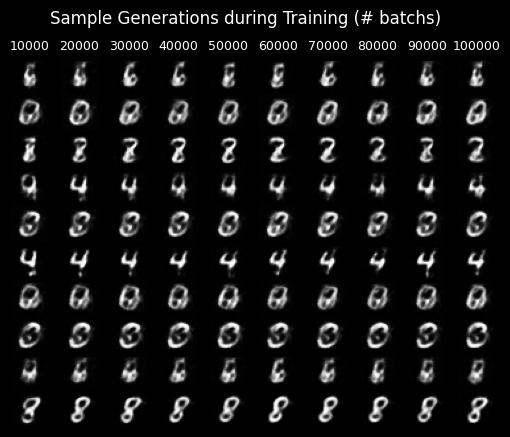

In [183]:
run_folder = "runs_vae_experiments"
run_id = "ae-grad_64_32_32_1_50.0_1e-06_0.0_1.0_0.01_0.5_64_0_100000_LeakyReLU_0.0"
run_fp = os.path.join(run_folder, run_id)
print(run_id)
samples_during_training(run_fp, end=100000, step=10000, fname="during_train_inf.png")

# run_folder = "runs_vae_tmp"
# run_id = "ae-grad_64_32_32_1_50.0_1e-06_0.05_0.05_0.01_0.5_64_0_48000_LeakyReLU_0.0"
# samples_during_training(run_fp, end=48000, step=4800, fname="during_train_inf.png")

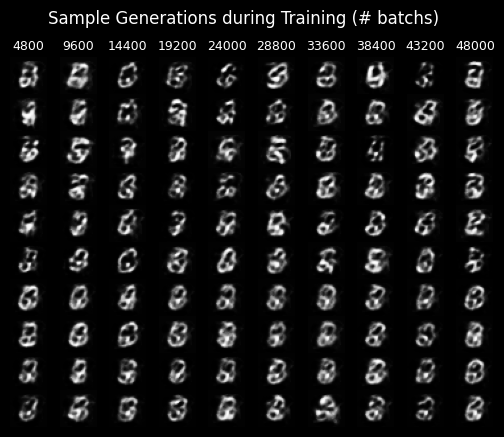

In [184]:
run_fp = df_best.loc[7, "run_fp"]
samples_during_training(run_fp, end=48000, step=4800, fname="during_train_367_7.png")

In [13]:
def list_latent():
    run_ids = os.listdir("runs_latent")
    for i in range(len(run_ids)):
        # run_ids[i] = os.path.join("runs_latent", run_ids[i])
        run_id = run_ids[i]
        print(run_id)

        run_id = run_id.split("/")[-1]
        run_fp = os.path.join('runs_latent/', run_id)
        args = parse_run_id(run_id)

        gen_fp = os.path.join(run_fp, 'netG_48000.pt')
        # Check if exists
        if not os.path.exists(gen_fp):
            print("Generator model not found")
            continue

        G = Generator_FC(args.hidden, args.nz, output_size=(100,)).to(device)
        G.load_state_dict(torch.load(gen_fp))
        G.eval()

        generate_samples(G, args, latent_type="wgan" if run_id.startswith("wgan") else "ae")

# Displays final models of all latent experiments (still using 
#   DPMI/AE extraction with DP-GAN)
#   NOTE: Everything here is mode collapsed
# list_latent()

wgan_32_64_32_1_50.0_1e-06_0.0_0.01_1e-05_0.5_64_1_48000_LeakyReLU_0.0
ae-enc_96_64_32_1_50.0_1e-06_0.0_0.001_5e-05_0.5_64_1_48000_Tanh_0.0
ae-grad_96_64_32_1_50.0_1e-06_0.0_0.005_5e-05_0.5_64_1_48000_Tanh_0.0


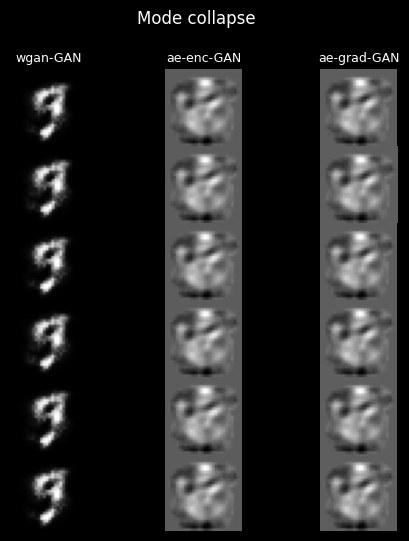

In [14]:
# Plot mode collapse
wgan_latent_sample_fp = "wgan_32_64_32_1_50.0_1e-06_0.0_0.01_1e-05_0.5_64_1_48000_LeakyReLU_0.0"
ae_enc_sample_fp = "ae-enc_96_64_32_1_50.0_1e-06_0.0_0.001_5e-05_0.5_64_1_48000_Tanh_0.0" 
ae_grad_sample_fp = "ae-grad_96_64_32_1_50.0_1e-06_0.0_0.005_5e-05_0.5_64_1_48000_Tanh_0.0"

imgs = []
for run_id in [wgan_latent_sample_fp, ae_enc_sample_fp, ae_grad_sample_fp]:
    run_fp = os.path.join("runs_latent", run_id)
    print(run_id)

    run_id = run_id.split("/")[-1]
    args = parse_run_id(run_id)

    gen_fp = os.path.join(run_fp, 'netG_48000.pt')

    G = Generator_FC(args.hidden, args.nz, output_size=(100,)).to(device)
    G.load_state_dict(torch.load(gen_fp))
    G.eval()

    fake = generate_samples(G, args, latent_type="wgan" if run_id.startswith("wgan") else "ae", plot=False, batch_size=6, seed=False)
    imgs.append(fake)

# Plot Sample Images
fig, ax = plt.subplots(6, 3, figsize=(6, 6))
titles = ["wgan-GAN", "ae-enc-GAN", "ae-grad-GAN"]
for j in range(3):
    for i in range(6):
        ax[i, j].imshow(imgs[j][i][0].detach().cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')
        if i == 0:
            ax[i, j].set_title(titles[j], color="white", fontsize=9)
fig.subplots_adjust(wspace=0, hspace=0)
fig.patch.set_facecolor('black')
fig.suptitle(f"Mode collapse", color="white", fontsize=12)
plt.savefig(f"{save_fp}/mode_collapse.png", bbox_inches='tight', pad_inches=0.25)
plt.show()

In [101]:
# Calculate IS and FID
wgan_latent_sample_fp = "wgan_32_64_32_1_50.0_1e-06_0.0_0.01_1e-05_0.5_64_1_48000_LeakyReLU_0.0"
ae_enc_sample_fp = "ae-enc_96_64_32_1_50.0_1e-06_0.0_0.001_5e-05_0.5_64_1_48000_Tanh_0.0" 
ae_grad_sample_fp = "ae-grad_96_64_32_1_50.0_1e-06_0.0_0.005_5e-05_0.5_64_1_48000_Tanh_0.0"

metrics = []
for run_id in [wgan_latent_sample_fp, ae_enc_sample_fp, ae_grad_sample_fp]:
    run_fp = os.path.join("runs_latent", run_id)
    print(run_id)

    run_id = run_id.split("/")[-1]
    args = parse_run_id(run_id)

    gen_fp = os.path.join(run_fp, 'netG_48000.pt')

    G = Generator_FC(args.hidden, args.nz, output_size=(100,)).to(device)
    G.load_state_dict(torch.load(gen_fp))
    G.eval()

    # Generate 2048 samples
    noise = torch.randn(2048, args.nz, device=device)
    print(f"noise: {noise.shape}")
    fake = G(noise)
    if run_id.startswith("wgan"):
        fake = pub_G(fake)
    else:
        fake = pub_Dec(fake)
    print(f"fake: {fake.shape}")

    # Calculate IS
    # IS = get_IS(fake)
    # print(f"IS: {IS}")

    # Calculate FID
    # FID = get_FID(fake)
    # print(f"FID: {FID}")

    # metrics.append((IS, FID))
print(metrics)
# IS: 1.0353781776270243, 1.0, 1.0
# FID: 211.49233816348095, 314.0779975260404, 339.6704685416357

wgan_32_64_32_1_50.0_1e-06_0.0_0.01_1e-05_0.5_64_1_48000_LeakyReLU_0.0
noise: torch.Size([2048, 64])
fake: torch.Size([2048, 1, 28, 28])
IS: 1.0353781776270243
ae-enc_96_64_32_1_50.0_1e-06_0.0_0.001_5e-05_0.5_64_1_48000_Tanh_0.0
noise: torch.Size([2048, 64])
fake: torch.Size([2048, 1, 28, 28])
IS: 1.0
ae-grad_96_64_32_1_50.0_1e-06_0.0_0.005_5e-05_0.5_64_1_48000_Tanh_0.0
noise: torch.Size([2048, 64])
fake: torch.Size([2048, 1, 28, 28])
IS: 1.0


[]

In [186]:
# Generating samples from gradient ascent
from model_inversion import gradient_ascent, projected_gradient_ascent

labeling_loader, public_loader, private_loader, test_loader = load_MNIST(10)

# Get a single batch of private images
imgs, _ = next(iter(private_loader))
imgs = imgs.to(device)

Loading MNIST splits from disk


In [187]:
iterations_list = [100, 200, 400, 1000, 5000, 100000, 200000]
n = len(iterations_list)

# Use pub_Enc and pub_Dec to encode/decode images
imgs_enc = pub_Dec(pub_Enc(imgs)).detach().cpu()

imgs_dec = []
imgs_gen = []
for iterations in iterations_list:
    # Perform gradient ascent
    latent_dec = gradient_ascent(
        pub_Dec, imgs, latent_dim=100, start_lr=200,
        iterations=iterations)

    # Perform projected gradient ascent
    latent_gen = projected_gradient_ascent(
        pub_G, imgs, latent_dim=100, start_lr=200,
        iterations=iterations, z_0_mult=1)
    
    # Decode the latent vectors
    imgs_dec.append(pub_Dec(latent_dec).detach().cpu())
    imgs_gen.append(pub_G(latent_gen).detach().cpu())
imgs = imgs.detach().cpu()

Loss: 0.16973838210105896
Loss: 0.10388829559087753
Loss: 0.15018373727798462
Loss: 0.10511275380849838
Loss: 0.1691935956478119
Loss: 0.10977935045957565
Loss: 0.17048072814941406
Loss: 0.09935171157121658
Loss: 0.15700671076774597
Loss: 0.10095573961734772
Loss: 0.15444009006023407
Loss: 0.006662027910351753
Loss: 0.006341173313558102
Loss: 0.006210915744304657
Loss: 0.10189367085695267
Loss: 0.03170761466026306
Loss: 0.16327370703220367
Loss: 0.0066819083876907825
Loss: 0.0063646468333899975
Loss: 0.1013847142457962
Loss: 0.03129978105425835


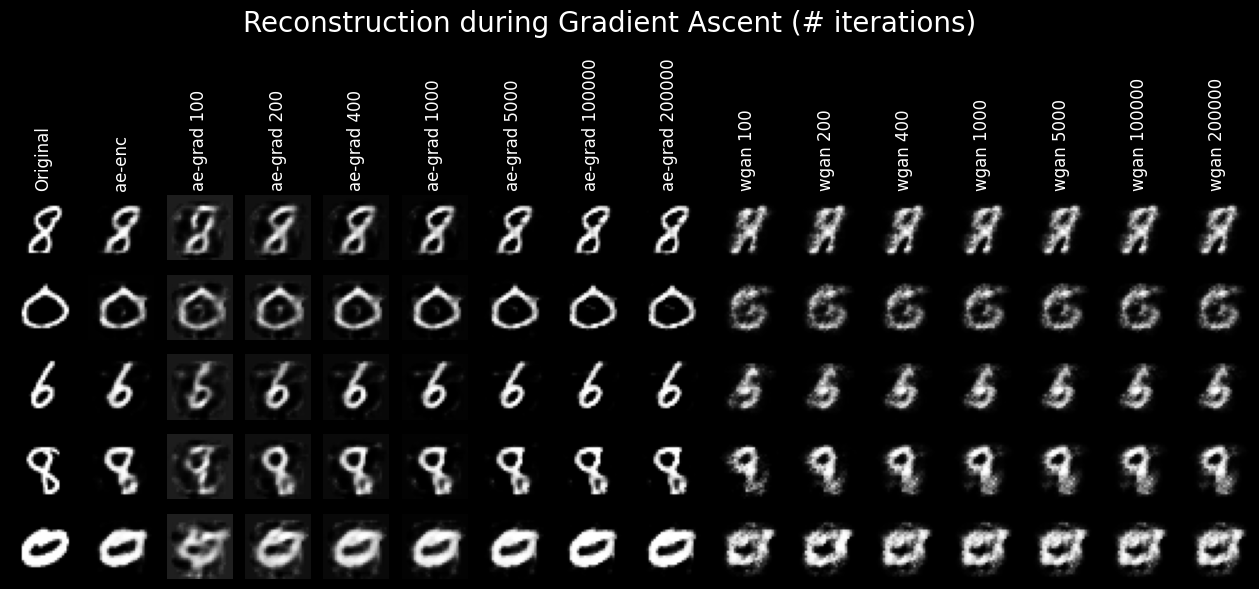

In [188]:
# Plot the images
rows = 5
fig, ax = plt.subplots(rows, 2*n + 2, figsize=(2*n + 2, rows))
rotation = 90
fontsize = 12
# Original images
for i in range(rows):
    ax[i, 0].imshow(imgs[i][0].detach().cpu().numpy(), cmap='gray')
    ax[i, 0].axis('off')
    if i == 0:
        # Rotated title
        ax[i, 0].set_title("Original", color="white", fontsize=fontsize,
            rotation=rotation)
# Decoded images
for i in range(rows):
    ax[i, 1].imshow(imgs_enc[i][0].detach().cpu().numpy(), cmap='gray')
    ax[i, 1].axis('off')
    if i == 0:
        ax[i, 1].set_title("ae-enc", color="white", fontsize=fontsize,
            rotation=rotation)
# Various iterations settings of gradient ascent (5 settings)
for i in range(rows):
    for j in range(n):
        ax[i, j+2].imshow(imgs_dec[j][i][0].detach().cpu().numpy(), cmap='gray')
        ax[i, j+2].axis('off')
        if i == 0:
            ax[i, j+2].set_title(f"ae-grad {iterations_list[j]}", 
                color="white", fontsize=fontsize, rotation=rotation)
# Various iterations settings of projected gradient ascent (5 settings)
for i in range(rows):
    for j in range(n):
        ax[i, j+n+2].imshow(imgs_gen[j][i][0].detach().cpu().numpy(), cmap='gray')
        ax[i, j+n+2].axis('off')
        if i == 0:
            ax[i, j+n+2].set_title(f"wgan {iterations_list[j]}", 
                color="white", fontsize=fontsize, rotation=rotation)
# Black background
fig.patch.set_facecolor('black')
plt.suptitle("Reconstruction during Gradient Ascent (# iterations)", color="white", fontsize=20, y=1.25)
plt.savefig(f"{save_fp}/gradient_ascent.png", bbox_inches='tight', pad_inches=0.25)
plt.show()

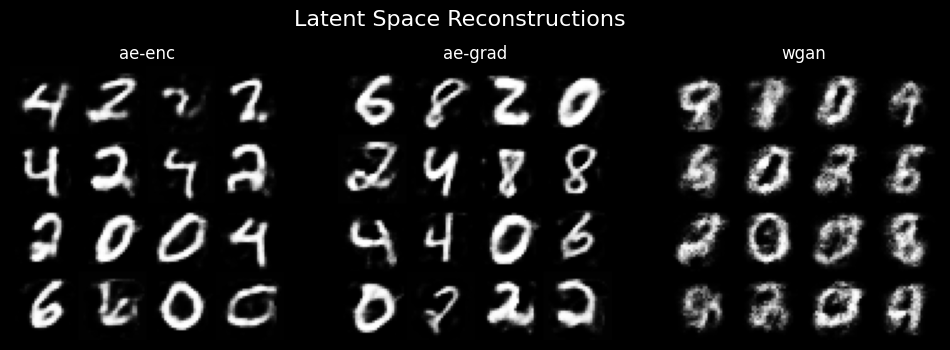

In [148]:
from data import load_latent
# Seed
torch.manual_seed(0)

# Load Latent Vectors
loader_ae_enc = load_latent(16, data_fp="data/ae_enc_latent_dataset.pt")
loader_ae_grad = load_latent(16, data_fp="data/ae_grad_latent_dataset.pt")
loader_wgan = load_latent(16, data_fp="data/wgan_latent_dataset.pt")

# Grab a single batch
batch_ae_enc = next(iter(loader_ae_enc))[0]
batch_ae_grad = next(iter(loader_ae_grad))[0]
batch_wgan = next(iter(loader_wgan))[0]

# Latent space to image space
images_ae_enc = pub_Dec(batch_ae_enc)
images_ae_grad = pub_Dec(batch_ae_grad)
images_wgan = pub_G(batch_wgan)

# Combine into 4x4 image
img_ae_enc = torch.Tensor(4*28, 4*28)
img_ae_grad = torch.Tensor(4*28, 4*28)
img_wgan = torch.Tensor(4*28, 4*28)
for i in range(4):
    for j in range(4):
        img_ae_enc[i*28:(i+1)*28, j*28:(j+1)*28] = images_ae_enc[i*4 + j][0]
        img_ae_grad[i*28:(i+1)*28, j*28:(j+1)*28] = images_ae_grad[i*4 + j][0]
        img_wgan[i*28:(i+1)*28, j*28:(j+1)*28] = images_wgan[i*4 + j][0]

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img_ae_enc.detach().cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[0].set_title("ae-enc", color="white", fontsize=12)
ax[1].imshow(img_ae_grad.detach().cpu().numpy(), cmap='gray')
ax[1].axis('off')
ax[1].set_title("ae-grad", color="white", fontsize=12)
ax[2].imshow(img_wgan.detach().cpu().numpy(), cmap='gray')
ax[2].axis('off')
ax[2].set_title("wgan", color="white", fontsize=12)
fig.patch.set_facecolor('black')
# Title
fig.suptitle("Latent Space Reconstructions", color="white", fontsize=16)
plt.savefig(f"{save_fp}/latent_samples.png", bbox_inches='tight', pad_inches=0.25)
plt.show()


In [ ]:
args
# 3,4,6*,8,9,10*,13*,16,19,20
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# * Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.005, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.01, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)

In [ ]:
# bad
args
# 0,1,2,5,7,11,12,14,15,17,18,21
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=0.0005, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=0.0005, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.02, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=0.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=50, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=3, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)
# Args(hidden=[128], nz=100, ngf=32, nc=1, epsilon='inf', delta=1e-06, noise_multiplier=0.0, c_p=0.0, lr=5e-05, beta1=0.0, batch_size=64, n_d=5, n_g=100000, activation='LeakyReLU', lambda_gp=10.0)

Loading runs_tmp/runs_gen_fc/public_128_100_32_1_inf_1e-06_0.0_0.02_5e-05_0.0_64_3_100000_LeakyReLU_0.0/netG_100000.pt


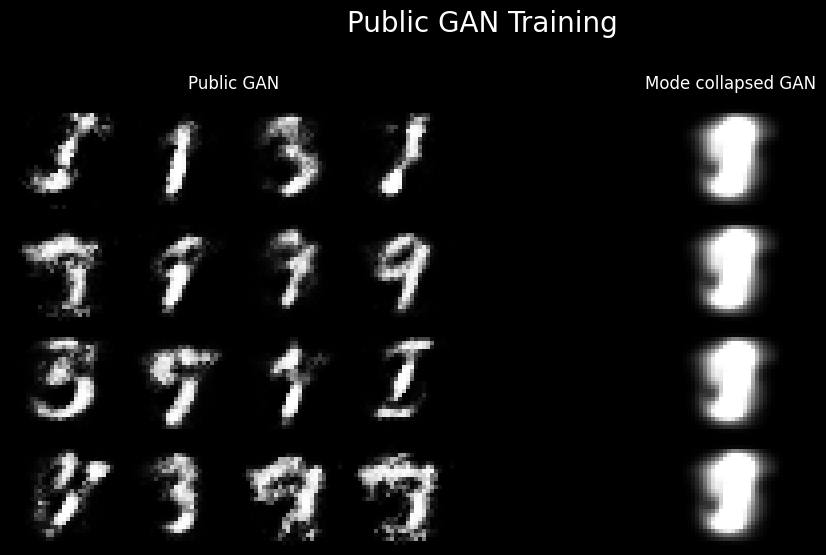

In [134]:
# Plot some public GAN samples
run_id = gen_fp.split("/")[-2]
args = parse_run_id(run_id)
imgs = generate_samples(pub_G, args, seed=True, plot=False, batch_size=16)

# Mode collapsed one
run_id = "public_128_100_32_1_inf_1e-06_0.0_0.02_5e-05_0.0_64_3_100000_LeakyReLU_0.0"
run_fp = os.path.join("runs_tmp/runs_gen_fc/", run_id)
args = parse_run_id(run_id)

gen_fp = os.path.join(run_fp, 'netG_100000.pt')
print("Loading {}".format(gen_fp))

G = Generator_FC([128], args.nz).to(device)
G.load_state_dict(torch.load(gen_fp))
G.eval()

imgs_2 = generate_samples(G, args, seed=True, plot=False, batch_size=16)

combined_img = torch.Tensor(4*28, 4*28)
combined_img_2 = torch.Tensor(4*28, 28)

# Combine image 1
for i in range(4):
    for j in range(4):
        combined_img[i*28:(i+1)*28, j*28:(j+1)*28] = imgs[i*4+j, 0, :, :]
# Combine image 2
for i in range(4):
    combined_img_2[i*28:(i+1)*28, :] = imgs_2[i, 0, :, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(combined_img.detach().numpy(), cmap='gray')
ax[0].set_title("Public GAN", color='white')
ax[0].axis('off')
ax[1].imshow(combined_img_2.detach().numpy(), cmap='gray')
ax[1].set_title("Mode collapsed GAN", color='white')
ax[1].axis('off')

fig.patch.set_facecolor('black')
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.suptitle("Public GAN Training", color='white', fontsize=20, y=1.1)
plt.savefig(f"{save_fp}/public_gan_training.png", pad_inches=0.1)
plt.show()


In [ ]:
# Plot images
rows = 

In [ ]:
fps = os.listdir("runs_tmp/runs_gen_fc/")

for idx in range(len(fps)):
    fp = os.path.join("runs_tmp/runs_gen_fc/", fps[idx])
    args = parse_run_id(fps[idx])

    gen_fp = os.path.join(fp, 'netG_100000.pt')
    if os.path.exists(gen_fp):
        print("Loading {}".format(gen_fp))
        
        G = Generator_FC([128], args.nz).to(device)
        G.load_state_dict(torch.load(gen_fp))
        G.eval()

        generate_samples(G, args)
# Mode collapse: 
# runs_tmp/runs_gen_fc/public_128_100_32_1_inf_1e-06_0.0_0.02_5e-05_0.0_64_3_100000_LeakyReLU_0.0/netG_100000.pt

In [ ]:
def plot_loss(run_fp):
    # Read loss.txt
    loss_fp = os.path.join(run_fp, 'loss.txt')
    epsilons = []
    d_loss, g_loss = [], []

    with open(loss_fp, 'r') as f:
        loss = f.read().splitlines()
        for i in range(len(loss)):
            if "time" in loss[i]:
                continue
            idx, l = loss[i].split(", ")

            if "." in idx:
                # Discriminator_FC Loss
                idx = int(float(idx))
                d_loss.append((idx, float(l)))
            else:
                # Generator Loss
                idx = int(float(idx))
                g_loss.append((idx, float(l)))

    # Graph Loss
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator_FC Loss During Training")
    plt.plot(*zip(*d_loss), label="Discriminator_FC")
    plt.plot(*zip(*g_loss), label="Generator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")

    # Only show first 100 epochs
    # plt.xlim(-10, 20000)
    plt.legend()
    plt.show()